In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19,vgg19
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
CONTENT_PATH="C:/Users/PratushPc/OneDrive/Documents/COURSES/DL SPECIALIZATION/4. Convolutional Neural Networks/4. Face Recognition - Neural Style Transfer/Custom Neural Style/images/content/"

STYLE_PATH="C:/Users/PratushPc/OneDrive/Documents/COURSES/DL SPECIALIZATION/4. Convolutional Neural Networks/4. Face Recognition - Neural Style Transfer/Custom Neural Style/images/style/"

### VGG-19 Model

In [3]:
base_model=VGG19(include_top=False,weights="imagenet",input_shape=(400,400,3))
base_model.trainable=False

In [4]:
print(len(base_model.layers))

middle_layer=base_model.layers[12]
print(middle_layer)

22


In [5]:
base_model.layers

### Loading And Preprocessing Data


In [ ]:
intermediate_model=Model(inputs=base_model.input,outputs=middle_layer.output)

### Content Cost Function

In [7]:
def compute_content_cost(a_C,a_G):
    
    m,n_h,n_w,n_c=a_G.shape

    a_C_unrolled=tf.reshape(tf.transpose(a_C,[3,1,2,0]),(n_c,-1))
    a_G_unrolled=tf.reshape(tf.transpose(a_G,[3,1,2,0]),(n_c,-1))

    J_content=tf.reduce_sum((a_C_unrolled-a_G_unrolled)**2)/(4*n_c*n_h*n_w)

    return J_content

### Style Cost Function

In [8]:
STYLE_LAYERS={
    "block1_conv2":0.2,
    "block2_conv2":0.3,
    "block3_conv2":0.4,
    "block4_conv2":0.5,
    "block5_conv2":0.6
}


def compute_style_cost(a_S_array,a_G_array):

    m,n_h,n_w,n_c=a_G_array[0].shape
    J_style=0   

    for i,lambd in enumerate(list(STYLE_LAYERS.values())):
        a_S_unroll=tf.reshape(tf.transpose(a_S_array[i],[3,1,2,0]),(n_c,-1))
        a_G_unroll=tf.reshape(tf.transpose(a_G_array[i],[3,1,2,0]),(n_c,-1))

        a_S_style=tf.matmul(a_S_unroll,tf.transpose(a_S_unroll))
        a_G_style=tf.matmul(a_G_unroll,tf.transpose(a_G_unroll))

        J_style_layer=tf.reduce_sum((a_G_style-a_S_style)**2)/(4*(n_c*n_h*n_w)**2)

        J_style+=J_style_layer*lambd

    return J_style


### Total Cost

In [9]:
def total_cost(J_content,J_style,alpha=10,beta=40):
    
    J_total=alpha*J_content + beta*J_style
    return J_total

### Load Content Images

(400, 400, 3)


(-0.5, 399.5, 399.5, -0.5)

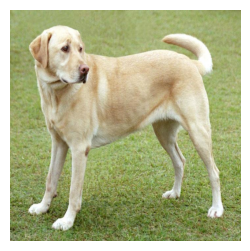

In [10]:
content_image=cv2.imread(CONTENT_PATH+"dogesh.jpg")
content_image=cv2.cvtColor(content_image,cv2.COLOR_BGR2RGB)
content_image=cv2.resize(content_image,(400,400))
content_image=content_image.astype("float32")/255.
print(content_image.shape)

plt.figure(figsize=(3,3))
plt.imshow(content_image)
plt.axis("off")

### Load Style Image

(400, 400, 3)


(-0.5, 399.5, 399.5, -0.5)

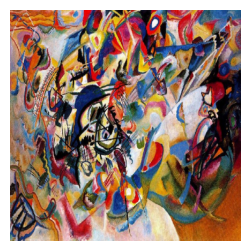

In [11]:
style_image=cv2.imread(STYLE_PATH+"art.jpg")
style_image=cv2.cvtColor(style_image,cv2.COLOR_BGR2RGB)
style_image=cv2.resize(style_image,(400,400))
style_image=style_image.astype("float32")/255.
print(style_image.shape)

plt.figure(figsize=(3,3))
plt.imshow(style_image)
plt.axis("off")

### Initializing Generated Image

(400, 400, 3)


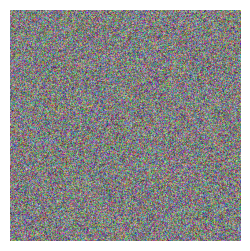

In [12]:
# generated_image = content_image.copy()
# generated_image=generated_image.astype("float32")
# # print(generated_image)
# noise = np.random.uniform(size=generated_image.shape,low=-0.8,high=0.8)
# generated_image = generated_image+noise
# generated_image = np.clip(generated_image,0.0,1.0)

generated_image=np.random.uniform(size=content_image.shape,low=0.0,high=1.0)

print(generated_image.shape)

plt.figure(figsize=(3,3))
plt.axis("off")
plt.imshow(generated_image)
plt.show()

### Getting a_C

In [ ]:
a_C=intermediate_model(np.expand_dims(content_image,axis=0))
print("a_C shape : ",a_C.shape)

a_C shape :  (1, 50, 50, 512)


### Calculating Content Cost

In [14]:
# J_content=compute_content_cost(a_C,a_G)
# print(J_content)

### Getting a_S_array

In [15]:
def get_layer_outputs(model):

    outputs=[model.get_layer(name).output for name in list(STYLE_LAYERS.keys())]
    
    temp_model=Model(inputs=[model.input],outputs=outputs)
    return temp_model

vgg_layer_outputs=get_layer_outputs(base_model)

In [16]:
a_S_array=vgg_layer_outputs(np.expand_dims(style_image,axis=0))
print(type(a_S_array),len(a_S_array))


<class 'list'> 5


### Calculating Style Cost

In [17]:
# J_style=compute_style_cost(a_S_array,a_G_array)
# print(J_style)

### Train Step

In [18]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)


# @tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:

        a_G=intermediate_model(generated_image)
        J_content=compute_content_cost(a_C,a_G)

        a_G_array=vgg_layer_outputs(generated_image)
        J_style=compute_style_cost(a_S_array,a_G_array)

        J=total_cost(J_content,J_style,alpha=1,beta=50)

    grad=tape.gradient(J,generated_image)
    optimizer.apply_gradients([(grad,generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image,0.0,1.0))

    return J

In [19]:

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return tensor

### Training The Model

In [20]:
generated_image=generated_image.astype(np.float32)
print(generated_image.dtype)

generated_image=tf.Variable(np.expand_dims(generated_image,axis=0))
# print(generated_image)

float32


epoch 0
tf.Tensor(415.15894, shape=(), dtype=float32)


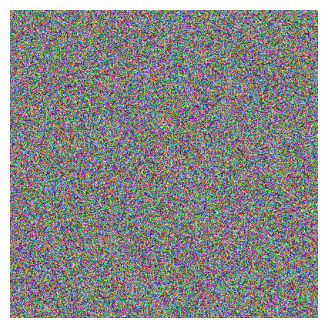

epoch 250
tf.Tensor(24.141207, shape=(), dtype=float32)


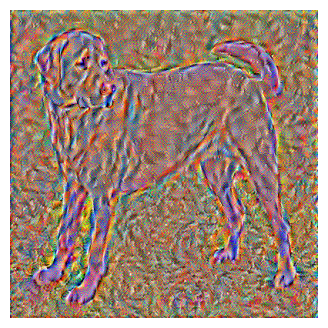

epoch 500
tf.Tensor(21.545029, shape=(), dtype=float32)


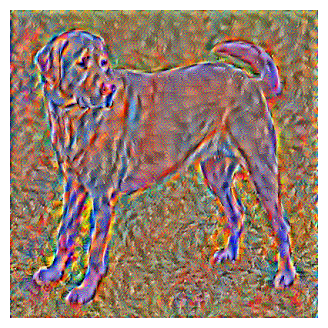

epoch 750
tf.Tensor(20.66513, shape=(), dtype=float32)


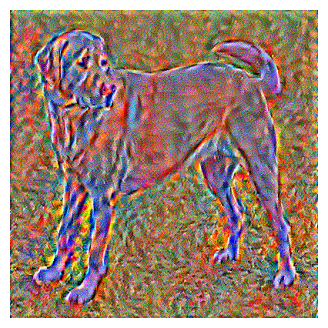

epoch 1000
tf.Tensor(20.224657, shape=(), dtype=float32)


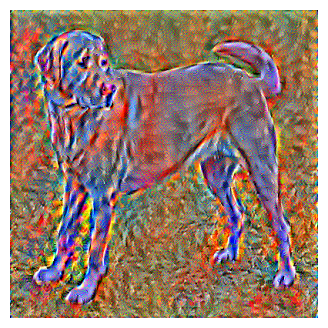

epoch 1250
tf.Tensor(19.963657, shape=(), dtype=float32)


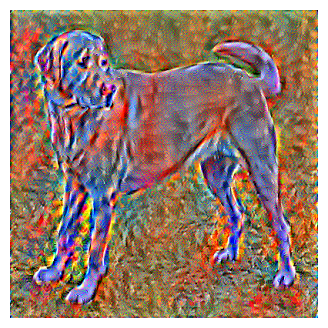

epoch 1500
tf.Tensor(19.792767, shape=(), dtype=float32)


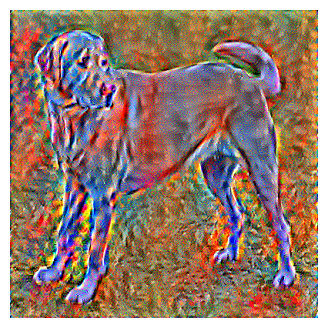

epoch 1750
tf.Tensor(19.669104, shape=(), dtype=float32)


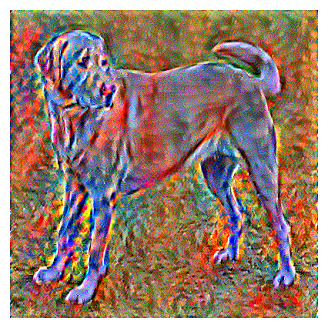

epoch 2000
tf.Tensor(19.57545, shape=(), dtype=float32)


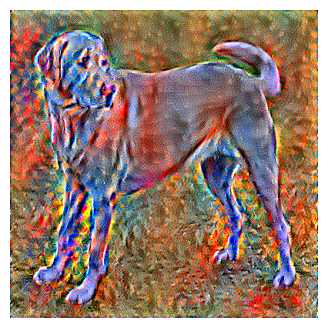

epoch 2250
tf.Tensor(19.500462, shape=(), dtype=float32)


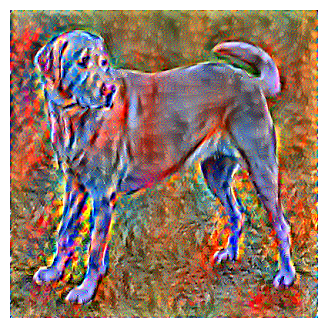

epoch 2500
tf.Tensor(19.438663, shape=(), dtype=float32)


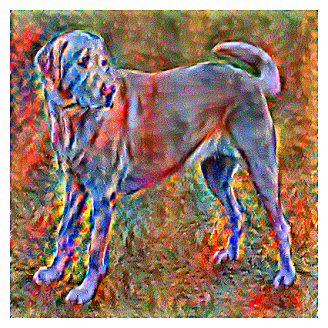

In [21]:

epochs = 2501
for i in range(epochs):
    loss=train_step(generated_image)
    if i%250==0:
        print(f"epoch {i}")
        print(loss)
        image=tensor_to_image(generated_image)
        plt.figure(figsize=(4,4))
        plt.imshow(image)
        plt.axis("off")
        plt.show()

(1, 400, 400, 3)


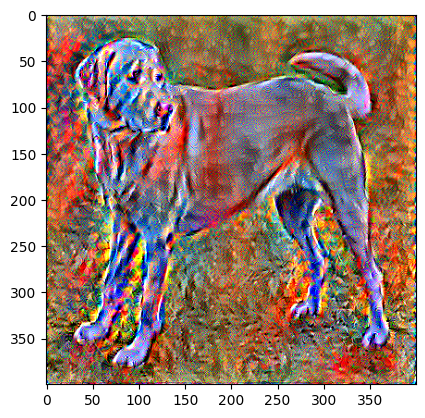

In [22]:
output_image=generated_image.numpy()
print(output_image.shape)
output_image=output_image[0]
# output_image=cv2.resize(output_image,(800,600))
output_image=(output_image*255).astype("int")

# print(output_image*255)
plt.imshow(output_image)

In [23]:
print(output_image.shape)

(400, 400, 3)
